# Car Insurance Claim

### Objective: 
To develop a predictive model that determines if a customer will submit a vehicle insurance claim in the next three months. This solution will help streamline financial planning at AutoInland and allow them to better serve their customers by understanding which customers are likely to submit a claim. Note: The outcome column indicates 1 if a customer has claimed his/her loan, else 0.



In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)
from sklearn.feature_selection import (VarianceThreshold, mutual_info_classif, RFE, SelectFromModel)

In [2]:
# load and view data
df = pd.read_csv('Car_Insurance_Claim.csv')
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [17]:
# information about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

In [5]:
df.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


Here are some key insights and observations from the descriptive statistics above:

1. There are 10,000 records.
2. The mean Credit Score is 515.8 which is quite low.
3. About 24% have a history of Driving Under the Influence (DUI).
4. The claim rate is 0.3133 (31.3%) indicating class imbalance.
5. Possible outliers in the following columns: SPEEDING_VIOLATIONS, DUIS, PAST_ACCIDENTS. Visualization will reveal more.
6. There are missing values in two columns: CREDIT_SCORE and ANNUAL_MILEAGE.
7. The ID column isn't necessary.

The descriptive statistics are focused on only the numerical columns. We also need to explore the categorical columns.

In [19]:
# Select only the categorical columns
cat_cols_df = df.select_dtypes(include='object')
cat_cols_df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,VEHICLE_YEAR,VEHICLE_TYPE
0,65+,female,majority,0-9y,high school,upper class,after 2015,sedan
1,16-25,male,majority,0-9y,none,poverty,before 2015,sedan
2,16-25,female,majority,0-9y,high school,working class,before 2015,sedan
3,16-25,male,majority,0-9y,university,working class,before 2015,sedan
4,26-39,male,majority,10-19y,none,working class,before 2015,sedan


In [30]:
# check unique counts for categorical columns
for i in cat_cols_df.columns:
    print(f"UNIQUE VALUES IN {i} COLUMN")
    print(df[i].value_counts())
    print("\n")

UNIQUE VALUES IN AGE COLUMN
AGE
26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: count, dtype: int64


UNIQUE VALUES IN GENDER COLUMN
GENDER
female    5010
male      4990
Name: count, dtype: int64


UNIQUE VALUES IN RACE COLUMN
RACE
majority    9012
minority     988
Name: count, dtype: int64


UNIQUE VALUES IN DRIVING_EXPERIENCE COLUMN
DRIVING_EXPERIENCE
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: count, dtype: int64


UNIQUE VALUES IN EDUCATION COLUMN
EDUCATION
high school    4157
university     3928
none           1915
Name: count, dtype: int64


UNIQUE VALUES IN INCOME COLUMN
INCOME
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: count, dtype: int64


UNIQUE VALUES IN VEHICLE_YEAR COLUMN
VEHICLE_YEAR
before 2015    6967
after 2015     3033
Name: count, dtype: int64


UNIQUE VALUES IN VEHICLE_TYPE COLUMN
VEHICLE_TYPE
sedan         9523
sports car     477
Name: count, dtype: int64




In [76]:
# get all numerical columns
num_cols = df._get_numeric_data()
num_cols.columns.tolist()

['ID',
 'CREDIT_SCORE',
 'VEHICLE_OWNERSHIP',
 'MARRIED',
 'CHILDREN',
 'POSTAL_CODE',
 'ANNUAL_MILEAGE',
 'SPEEDING_VIOLATIONS',
 'DUIS',
 'PAST_ACCIDENTS',
 'OUTCOME']

In [54]:
#check for duplicates
df.duplicated().sum()

0

### DATA VISUALIZATION

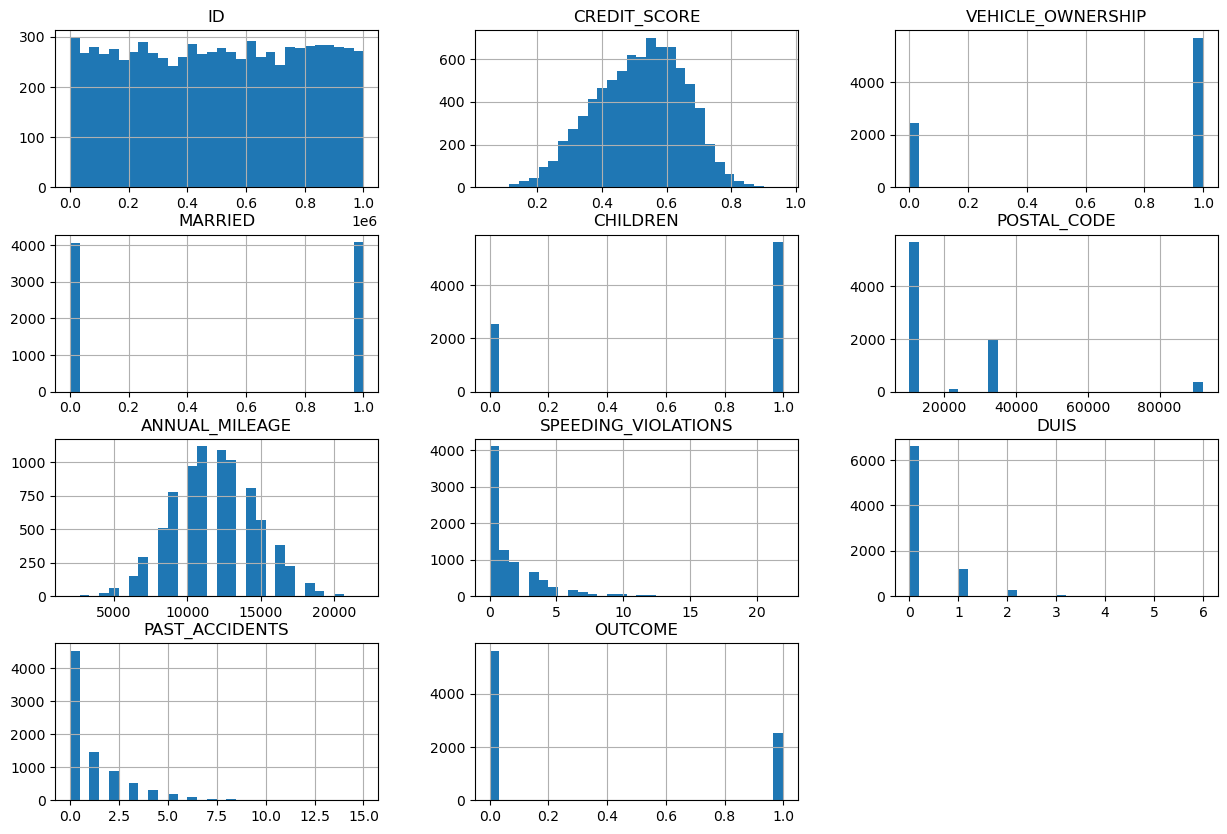

In [81]:
# visualise distribution of numerical columns
num_cols.hist(bins=30, figsize=(15, 10));
plt.title("DISTIBUTION OF NUMERICAL COLUMNS");
plt.show()
    

### DATA CLEANING

### 1. Missing values

In [40]:
# check number of missing records
missing = df[df['CREDIT_SCORE'].isnull() | df['ANNUAL_MILEAGE'].isnull()==True]
print(f'There are {len(missing)} missing records.')
print(f'This is {len(missing)*100/len(df)}% of the dataset.')

There are 1851 missing records.
This is 18.51% of the dataset.


In [55]:
df = df.dropna(subset=['CREDIT_SCORE', 'ANNUAL_MILEAGE'])
print(f"Dropped missing values. New dataset size: {len(df):,}\n")

Dropped missing values. New dataset size: 8,149



### 2. Handling Outliers

In [100]:
# check for outliers
outlier_summary = {}
for col in num_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR  # Using 3*IQR 
        upper_bound = Q3 + 3 * IQR
            
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_summary[col] = outliers
            
        if outliers > 0:
            print(f"{col:20s}: {outliers:4d} outliers ({outliers/len(df)*100:.1f}%)")

SPEEDING_VIOLATIONS :  151 outliers (1.9%)
DUIS                : 1543 outliers (18.9%)
PAST_ACCIDENTS      :   35 outliers (0.4%)


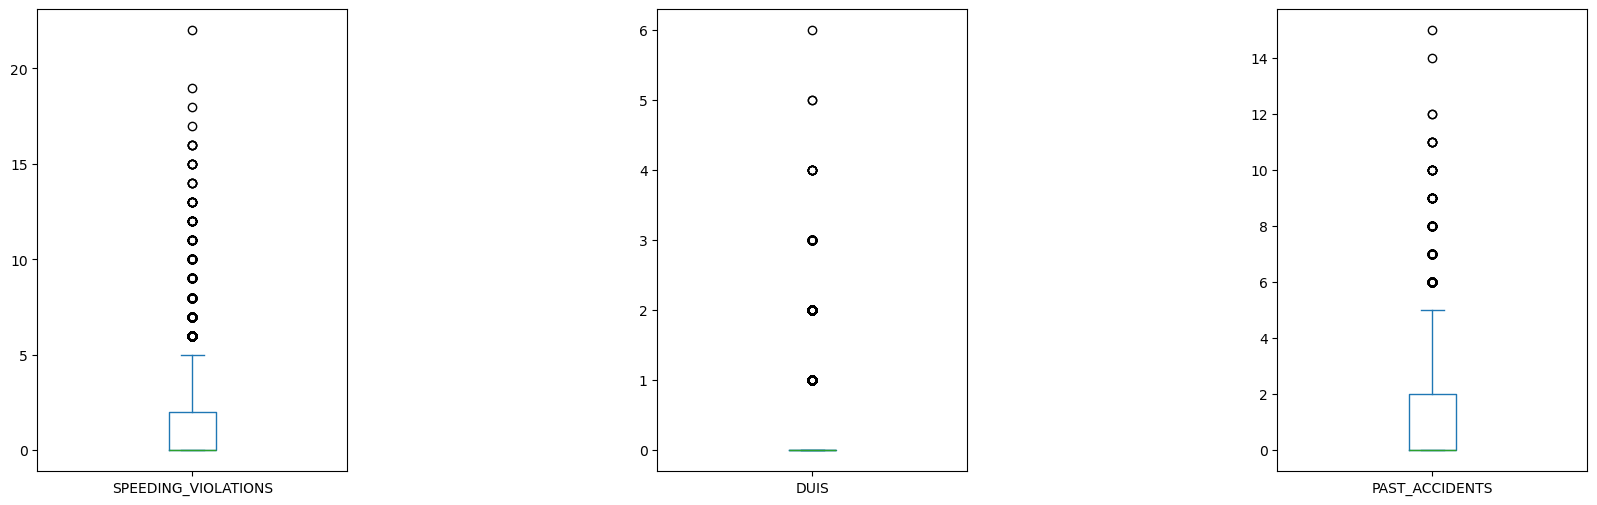

In [101]:
num_cols[['SPEEDING_VIOLATIONS','DUIS','PAST_ACCIDENTS']].plot(kind='box', subplots=True, sharey=False, figsize=(20, 6));
# Adjust spacing between subplots for better readability
plt.subplots_adjust(wspace=1)
plt.show()

These outliers are REAL high-risk customers - not data errors.

1. 22 speeding violations = chronic offender 
2. 6 DUIs = serial offender 
3. 15 accidents = extremely high-risk driver (real person)

These are the people that are most likely to file claims.
Removing them means losing predictive power. Binning them would cause these extreme cases to be diluted. The model won't be able to tell that someone with 15 accidents is more likely to file a claim than someone with 2. 

The model needs to learn from these high-risk behavior, so I will keep the outliers.

### EXPLORATORY DATA ANALYSIS

### Univariate Analysis - Outcome Distribution

In [227]:
claim_rate = df['OUTCOME'].value_counts()[1]/len(df)
print(f'The overall claim rate is {claim_rate*100:.2f}%')

The overall claim rate is 31.12%


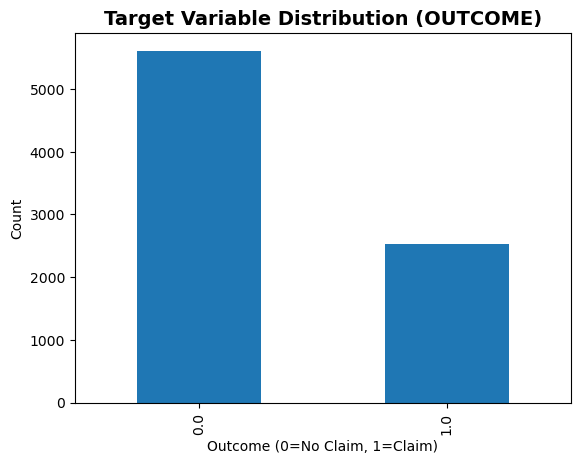

In [106]:
df['OUTCOME'].value_counts().plot(kind='bar');
plt.title('Target Variable Distribution (OUTCOME)', fontsize=14, fontweight='bold')
plt.xlabel('Outcome (0=No Claim, 1=Claim)')
plt.ylabel('Count');

The distribution shows an imbalanced dataset (31: 69) which will be handled with SMOTE and compared without handling to choose which produces best predictive model.

### Bivariate Analysis

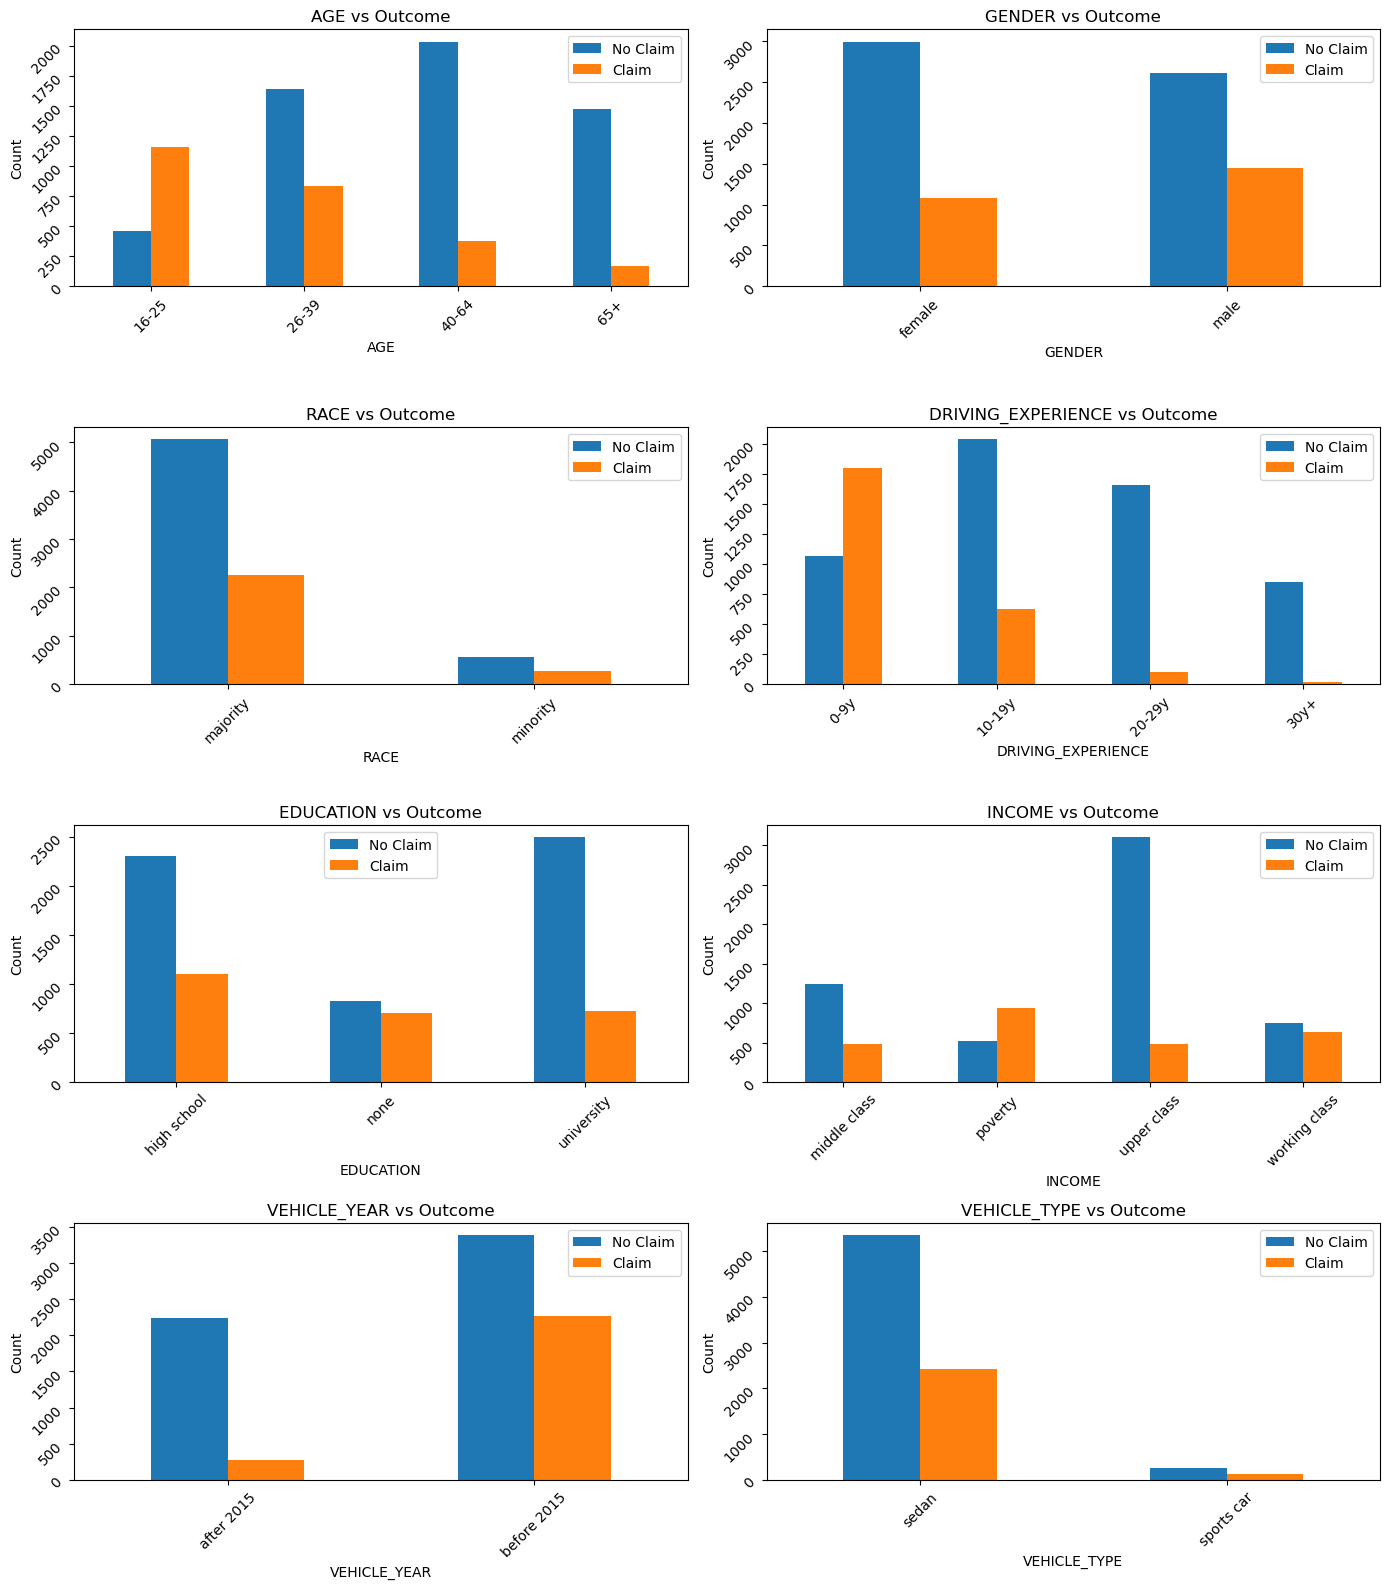

In [119]:
# Calculate grid
n_cols = len(cat_cols_df.columns)
n_rows = (n_cols + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(14, n_rows * 4))
axes = axes.flatten() if n_cols > 1 else [axes]
    
for idx, col in enumerate(cat_cols_df):
    ax = axes[idx]
        
    # Count plot (stacked bars for No Claim vs Claim)
    df_grouped = df.groupby([col, 'OUTCOME']).size().unstack(fill_value=0)
    df_grouped.plot(kind='bar', stacked=False, ax=ax, legend=True)
        
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_title(f'{col} vs Outcome')
    ax.legend(['No Claim', 'Claim'])
    ax.tick_params(rotation=45) 
        
        
# Hide empty subplots
for idx in range(n_cols, len(axes)):
    axes[idx].axis('off')
    
plt.tight_layout()
plt.show()
    
 

Considering the fact that there are more records of no claims, it would make more sense to plot against claim rate to actually see and compare the proportions of each sub-group in the category that claimed.

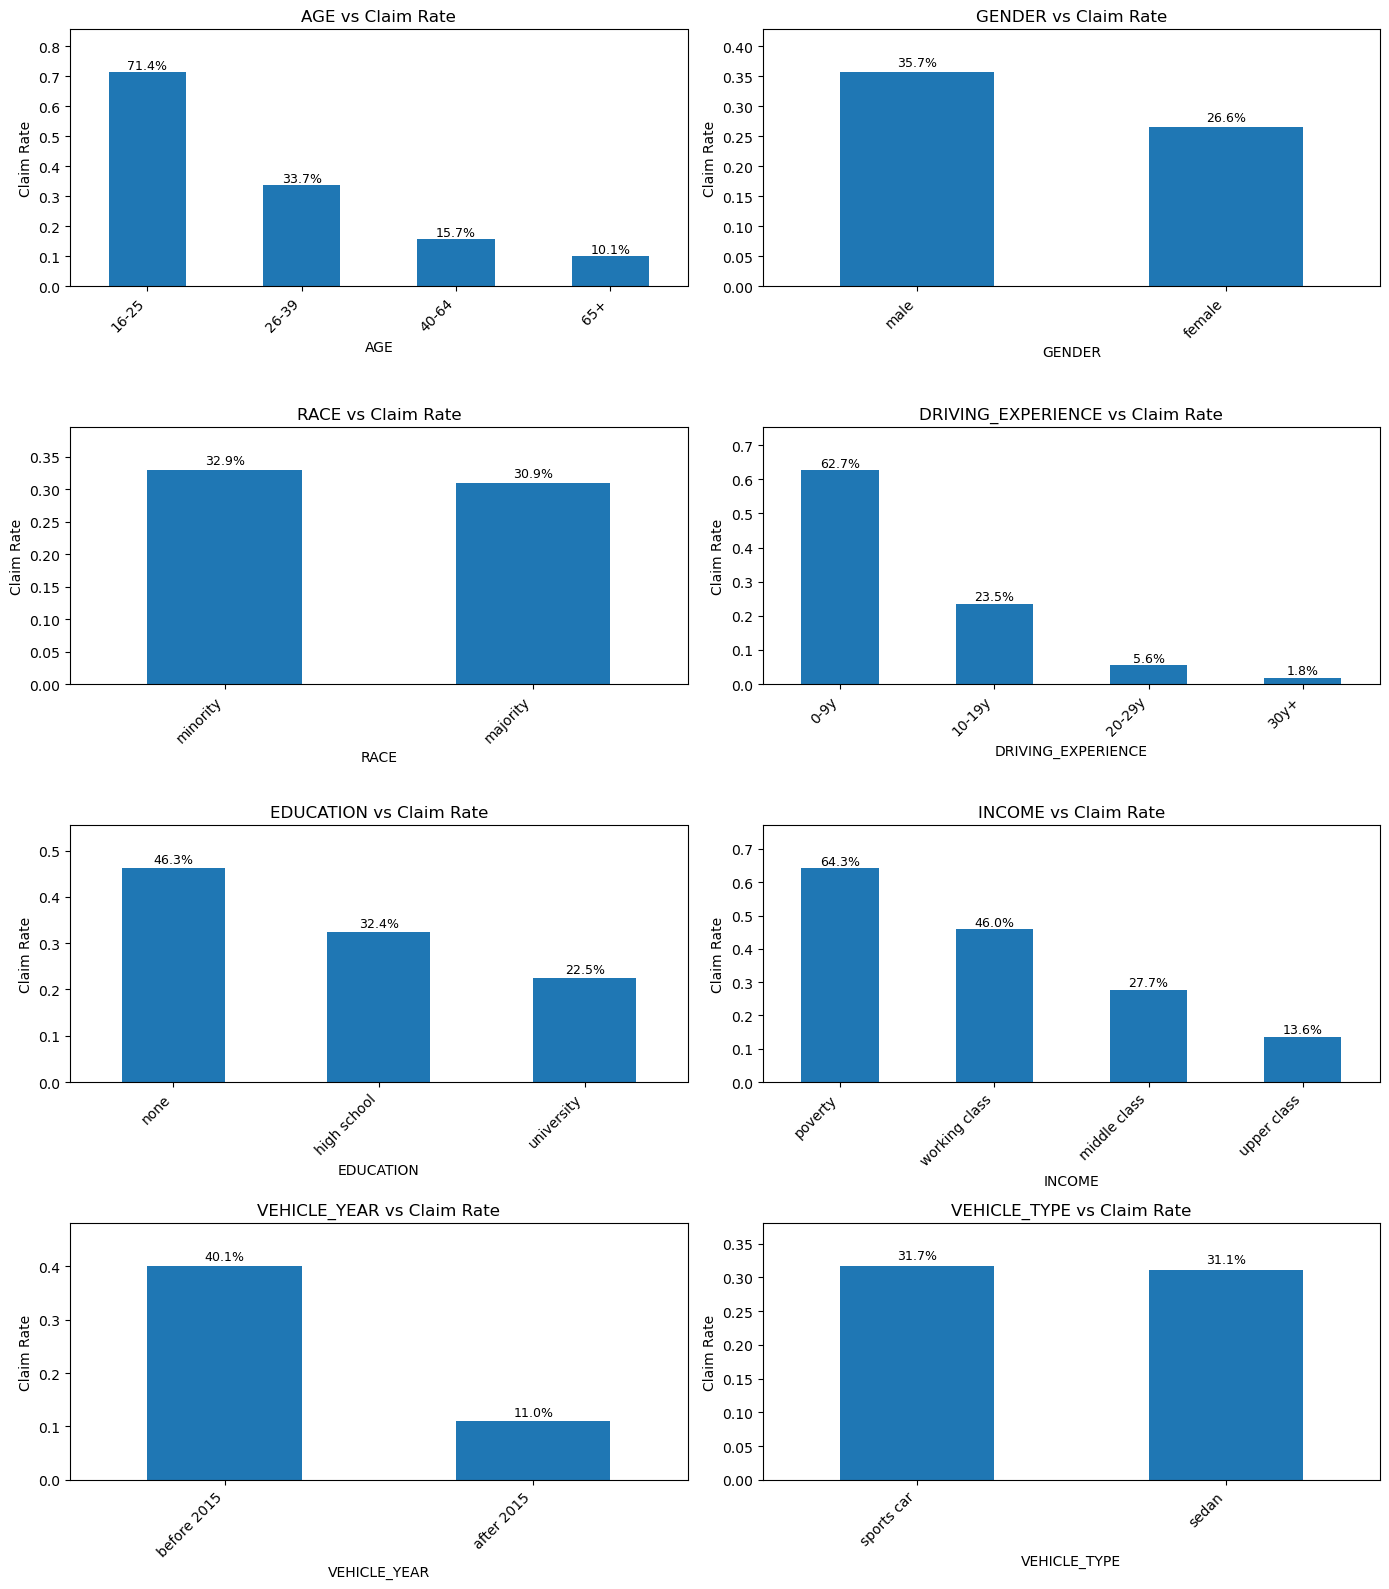

In [112]:
# Calculate grid
n_cols = len(cat_cols_df.columns)
n_rows = (n_cols + 1) // 2
    
fig, axes = plt.subplots(n_rows, 2, figsize=(14, n_rows * 4))
axes = axes.flatten() if n_cols > 1 else [axes]
    
for idx, col in enumerate(cat_cols_df):
    ax = axes[idx]
        
    # Calculate claim rate
    claim_rate = df.groupby(col)['OUTCOME'].mean().sort_values(ascending=False)
        
    # Bar plot
    claim_rate.plot(kind='bar', ax=ax)
    ax.set_ylabel('Claim Rate')
    ax.set_xlabel(col)
    ax.set_title(f'{col} vs Claim Rate')
    ax.set_ylim([0, claim_rate.max() * 1.2])
        
    # Add percentage labels
    for i, v in enumerate(claim_rate):
        ax.text(i, v + 0.01, f'{v:.1%}', ha='center', fontsize=9)
        
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
# Hide empty subplots
for idx in range(n_cols, len(axes)):
    axes[idx].axis('off')
    
plt.tight_layout()
plt.show()
    


From the visualizations above, the categories with the highest claim rates can be seen.

### Correlation Analysis

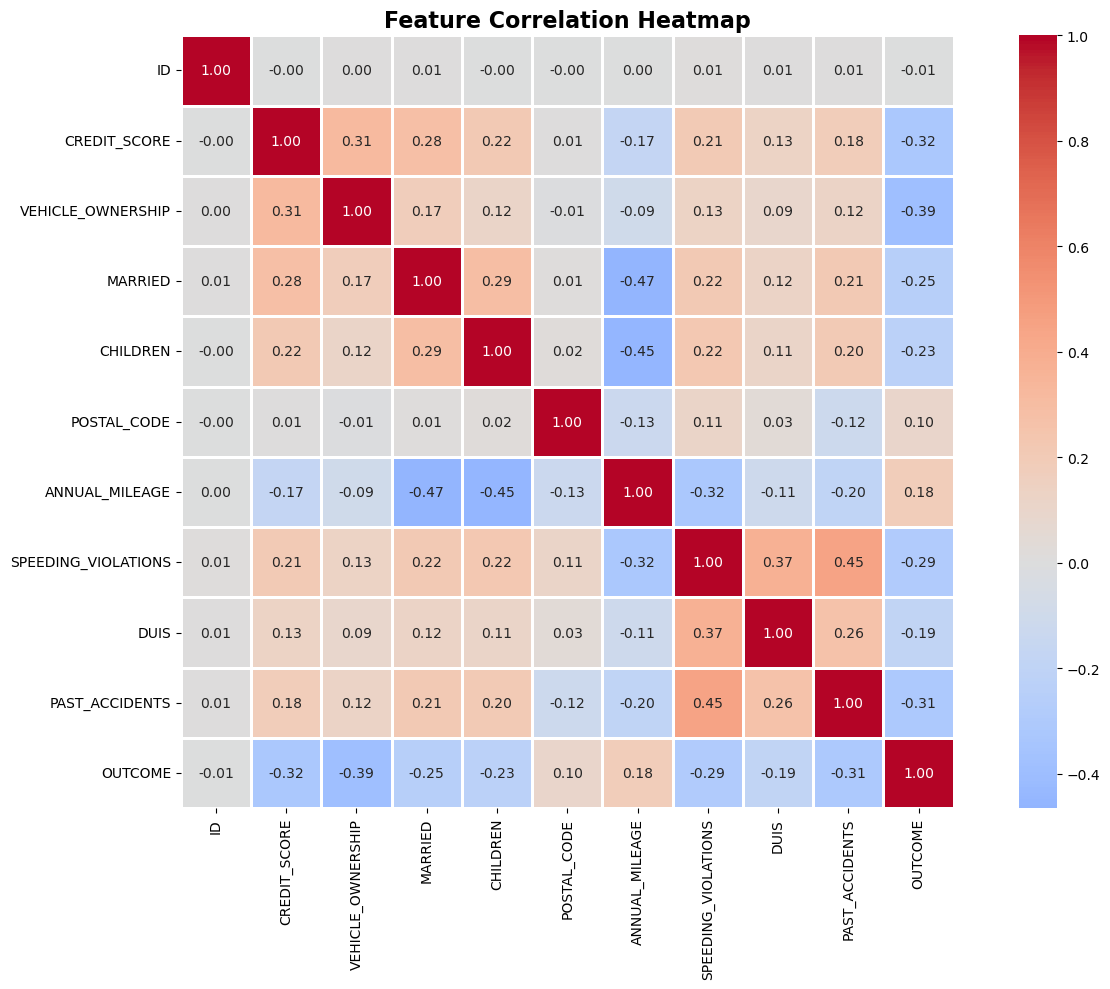

In [124]:
# Correlation Analysis
correlation_matrix = num_cols.corr()
    
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

<b> Observations
1. ID and POSTAL_CODE columns have almost no correlations with any columns, including the OUTCOME column. So, they will be dropped.

In [125]:
df = df.drop(columns =['ID', 'POSTAL_CODE'],axis=1)
df.columns

Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'MARRIED',
       'CHILDREN', 'ANNUAL_MILEAGE', 'VEHICLE_TYPE', 'SPEEDING_VIOLATIONS',
       'DUIS', 'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')

### Feature Selection - Chi Square Test

In [142]:
# Chi-square test
chi_square_results = []
from scipy.stats import chi2_contingency
for col in df.columns:
    contingency = pd.crosstab(df[col], df['OUTCOME'])
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    chi_square_results.append({
            'Feature': col,
            'Chi2': chi2,
            'p-value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

results_df = pd.DataFrame(chi_square_results)
results_df_sorted = results_df.sort_values('Chi2', ascending=False)
    
print("\n" + results_df_sorted.to_string(index=False))
    


            Feature        Chi2       p-value Significant
       CREDIT_SCORE 8149.000000  4.947917e-01          No
            OUTCOME 8144.335531  0.000000e+00         Yes
 DRIVING_EXPERIENCE 2286.034849  0.000000e+00         Yes
                AGE 1845.380399  0.000000e+00         Yes
             INCOME 1414.838118 1.775851e-306         Yes
   TOTAL_VIOLATIONS 1383.134067 3.857810e-280         Yes
SPEEDING_VIOLATIONS 1244.781440 1.960041e-251         Yes
  VEHICLE_OWNERSHIP 1213.715593 6.375762e-266         Yes
     PAST_ACCIDENTS 1211.292932 6.477108e-250         Yes
       VEHICLE_YEAR  684.584719 6.728394e-151         Yes
            MARRIED  521.342446 2.160109e-115         Yes
           CHILDREN  430.963666  1.002644e-95         Yes
               DUIS  352.574842  4.322007e-73         Yes
     ANNUAL_MILEAGE  318.825093  1.137675e-55         Yes
          EDUCATION  276.909702  7.410070e-61         Yes
             GENDER   78.760089  7.012966e-19         Yes
             

In [149]:
df = df.drop(columns=['CREDIT_SCORE', 'RACE', 'VEHICLE_TYPE'],axis=1)
df.columns

Index(['AGE', 'GENDER', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS',
       'OUTCOME', 'TOTAL_VIOLATIONS'],
      dtype='object')

### Data Preprocessing

In [240]:
# Encode categorical variables
df_processed = df_processed.copy()

# Encode categorical variables
label_encoders = {}
    
for col in df_processed.select_dtypes(include='object'):
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

In [206]:
# split data
X = df_processed.drop('OUTCOME', axis=1)
y = df_processed['OUTCOME']

In [201]:
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (8149, 12)
Target shape: (8149,)


In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### MODEL TRAINING AND EVALUATION

In [220]:
# Initialize models
models = {
        'Logistic Regression': LogisticRegression(random_state=42,max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42,max_depth=10, min_samples_split=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42,max_depth=5, learning_rate=0.1)
    }
def train(X_train_scaled,X_test_scaled, models):
    
    
    results = {}
    trained_models = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n{'='*40}")
        print(f"Training: {name}")
        print(f"{'='*40}")
        
        # Train
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot()
        plt.show()
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        trained_models[name] = model
        
        # Print metrics
        print(f"\nPerformance Metrics:")
        print(f"  Accuracy:    {accuracy:.4f}")
        print(f"  Precision:   {precision:.4f}")
        print(f"  Recall:      {recall:.4f}")
        print(f"  F1-Score:    {f1:.4f}")
        print(f"  ROC-AUC:     {roc_auc:.4f}")
    
    return results, trained_models, X_test, y_test, scaler


Training: Logistic Regression


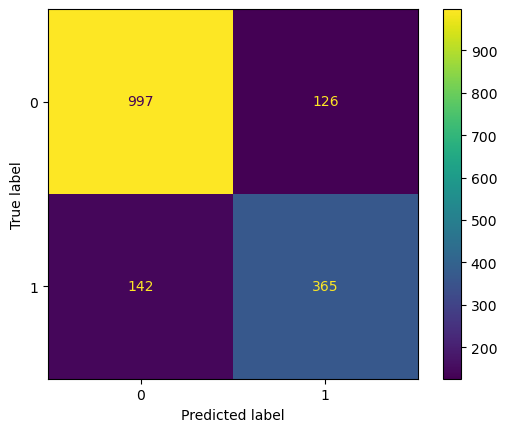


Performance Metrics:
  Accuracy:    0.8356
  Precision:   0.7434
  Recall:      0.7199
  F1-Score:    0.7315
  ROC-AUC:     0.8943

Training: Random Forest


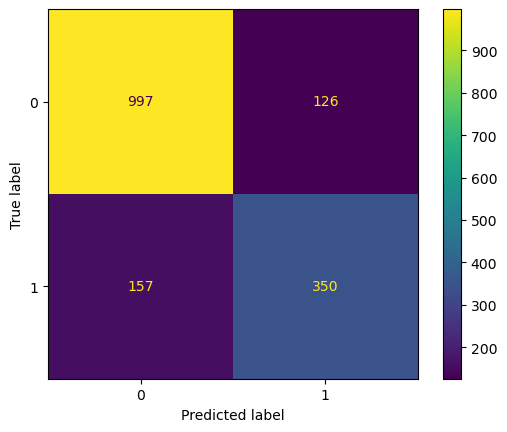


Performance Metrics:
  Accuracy:    0.8264
  Precision:   0.7353
  Recall:      0.6903
  F1-Score:    0.7121
  ROC-AUC:     0.8904

Training: Gradient Boosting


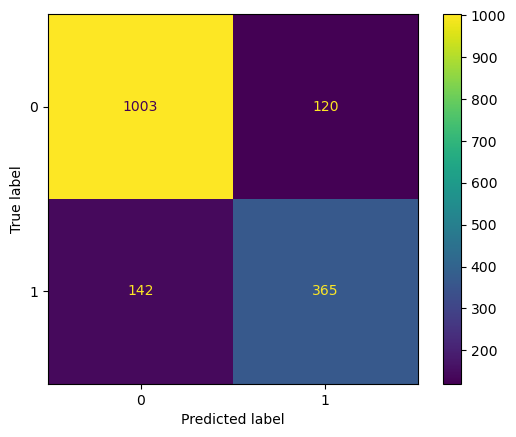


Performance Metrics:
  Accuracy:    0.8393
  Precision:   0.7526
  Recall:      0.7199
  F1-Score:    0.7359
  ROC-AUC:     0.8915


In [221]:
results, trained_models, X_test, y_test, scaler = train(X_train_scaled,X_test_scaled,models)

### Compare SMOTE Sampling

Try 69% to 31% sampling since target distribution is 69% to 31%.


Original training distribution: Counter({0.0: 4490, 1.0: 2029})
After SMOTE: Counter({0.0: 4490, 1.0: 3098})

Training: Logistic Regression


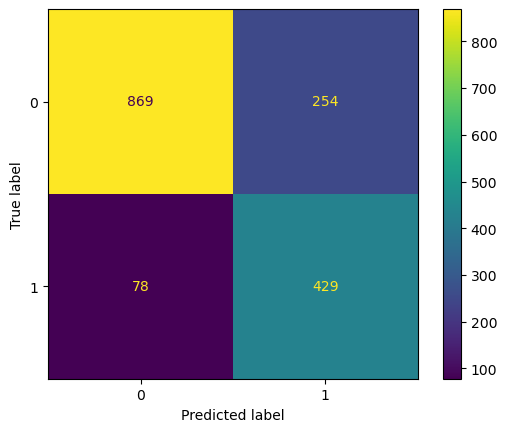


Performance Metrics:
  Accuracy:    0.7963
  Precision:   0.6281
  Recall:      0.8462
  F1-Score:    0.7210
  ROC-AUC:     0.8942

Training: Random Forest


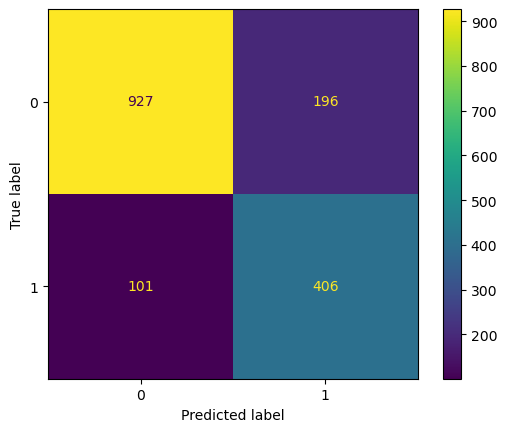


Performance Metrics:
  Accuracy:    0.8178
  Precision:   0.6744
  Recall:      0.8008
  F1-Score:    0.7322
  ROC-AUC:     0.8900

Training: Gradient Boosting


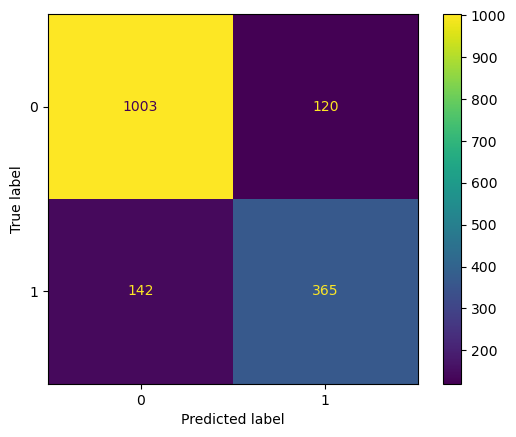


Performance Metrics:
  Accuracy:    0.8393
  Precision:   0.7526
  Recall:      0.7199
  F1-Score:    0.7359
  ROC-AUC:     0.8915


In [228]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE (only to training data!)
print(f"\nOriginal training distribution: {Counter(y_train)}")
smote = SMOTE(random_state=42, sampling_strategy=0.69)  # Minority = 70% of majority
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: {Counter(y_train_balanced)}")
    
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)
    
models2 = {
        'Logistic Regression': LogisticRegression(class_weight='balanced',random_state=42,max_iter=10000),
        'Random Forest': RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=42,max_depth=10, min_samples_split=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42,max_depth=5, learning_rate=0.1)
    }

results, trained_models, X_test, y_test, scaler = train(X_train_scaled,X_test_scaled,models2)

Comparing the metrics from the SMOTE sampling and without SMote sampling, observe that the recall improved for both the Logistic Regression and Random Forest models after SMOTE Sampling.

Considering the essence of this project, it is more beneficial to minimize false negatives.

In this case, False Negatives are data points where the model predicted a No Claim when it was actually a Claim. We want to minimise this occurrence and applying the SMOTE sampling ensures we catch at least 80% of all claims correctly. Also notice that the precision reduced in this case but it still maintained above 60% which is acceptable.

### Adjust Model to Minimize False Negatives
Try assigning classweights of 1:3.


Training: Logistic Regression


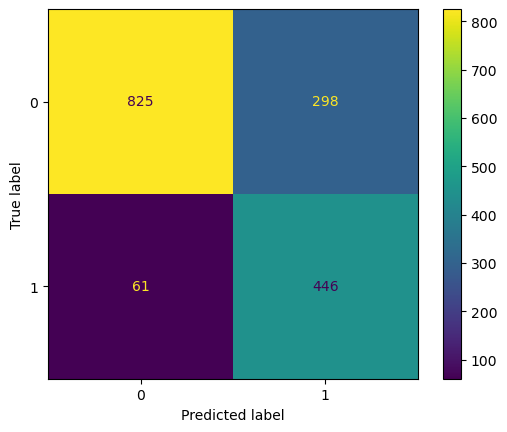


Performance Metrics:
  Accuracy:    0.7798
  Precision:   0.5995
  Recall:      0.8797
  F1-Score:    0.7130
  ROC-AUC:     0.8942

Training: Random Forest


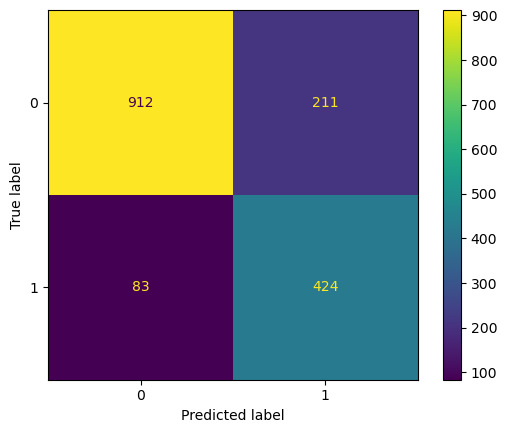


Performance Metrics:
  Accuracy:    0.8196
  Precision:   0.6677
  Recall:      0.8363
  F1-Score:    0.7426
  ROC-AUC:     0.8893

Training: Gradient Boosting


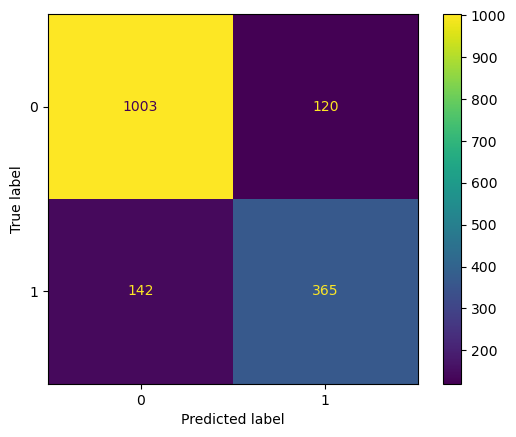


Performance Metrics:
  Accuracy:    0.8393
  Precision:   0.7526
  Recall:      0.7199
  F1-Score:    0.7359
  ROC-AUC:     0.8915


In [229]:
# Use class weights to penalize False Negatives more
class_weights = {
    0: 1,      # No claim - normal weight
    1: 3       # Claim - 3x weight (penalize missing these!)
}
models3 = {
        'Logistic Regression': LogisticRegression(class_weight=class_weights,random_state=42,max_iter=10000),
        'Random Forest': RandomForestClassifier(class_weight=class_weights,n_estimators=100, random_state=42,max_depth=10, min_samples_split=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42,max_depth=5, learning_rate=0.1)
    }

results, trained_models, X_test, y_test, scaler = train(X_train_scaled,X_test_scaled,models3)

From these experimentations and comparison of metrics, the Random Forest model seems to be the best with the highest recall, acceptable precision, high ROC-AUC and high accuracy.

Some feature selection was done earlier, however, tree based models do not really need prior feature selection as it is already part of the model. Let's check the most important features according to these models.

In [236]:
def plot_feature_importance(trained_models, X):
    print("FEATURE IMPORTANCE ANALYSIS")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for idx, name in enumerate(['Random Forest', 'Gradient Boosting']):
        if name in trained_models:
            model = trained_models[name]
            importances = model.feature_importances_
            indices = np.argsort(importances)[-10:]  # Top 10 features
            
            ax = axes[idx]
            ax.barh(range(len(indices)), importances[indices], color='#3498db', alpha=0.7)
            ax.set_yticks(range(len(indices)))
            ax.set_yticklabels([X.columns[i] for i in indices])
            ax.set_xlabel('Importance Score', fontsize=11)
            ax.set_title(f'{name}\nTop 15 Feature Importances', fontsize=13, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

FEATURE IMPORTANCE ANALYSIS


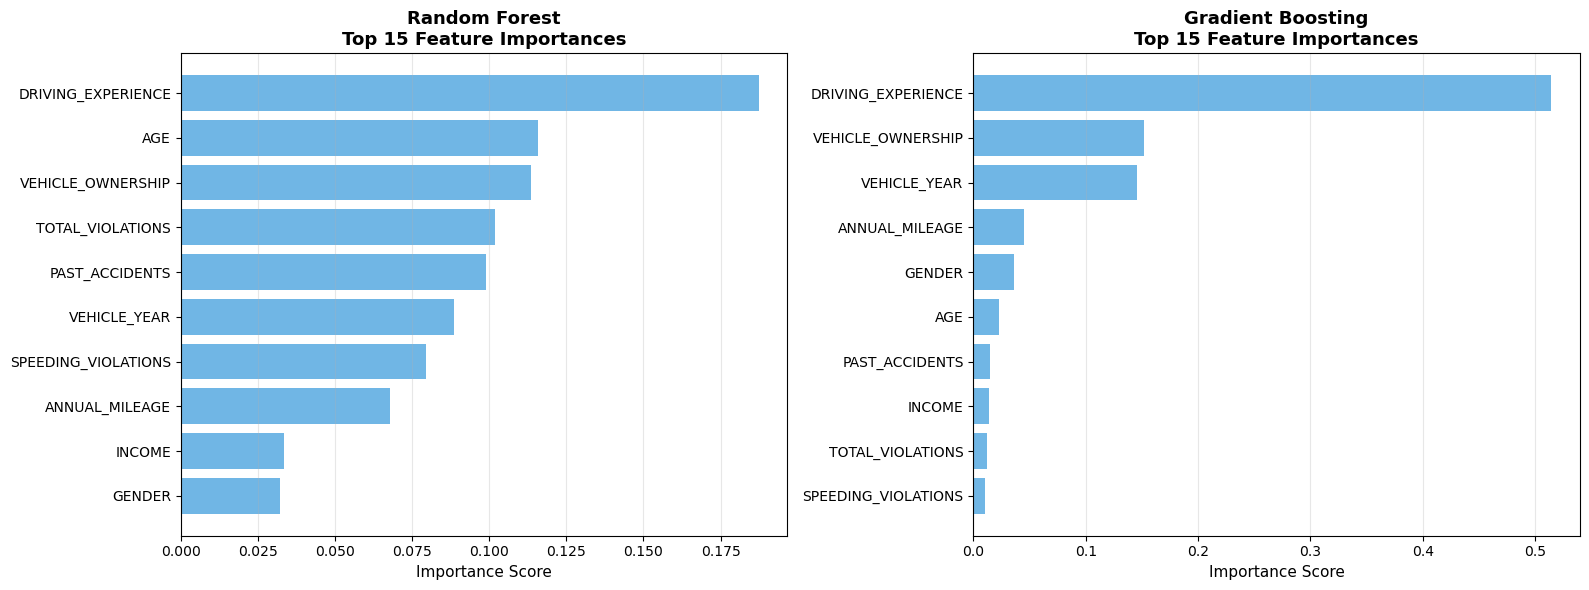

In [237]:
plot_feature_importance(trained_models, X)

In [241]:
#saving the best model

joblib.dump(trained_models, 'best_model.pkl')

['best_model.pkl']

In [242]:
#saving the scaler

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']